<a href="https://colab.research.google.com/github/MiroDur/MuScat_Miro/blob/master/DataReconstructionFromSimCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install phantominator
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.7 MB/s 


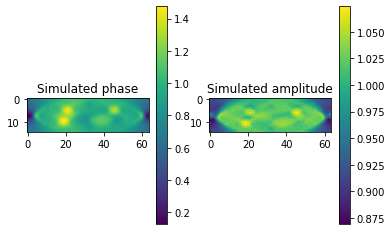

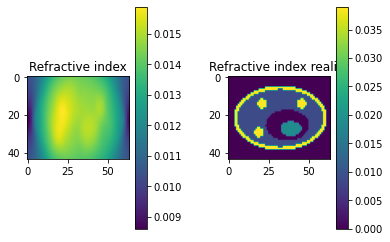

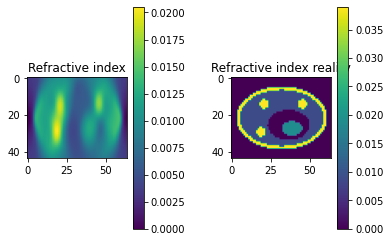

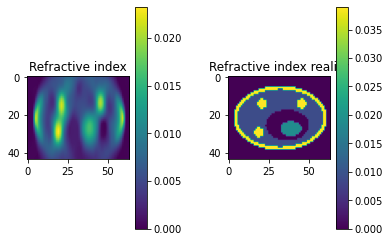

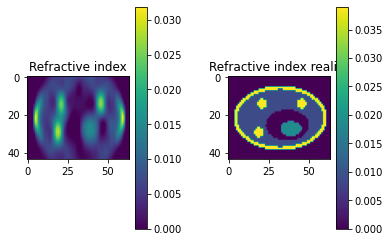

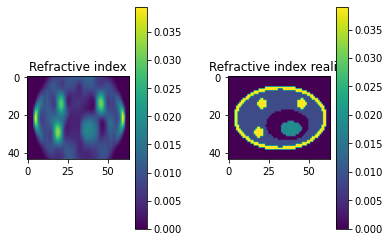

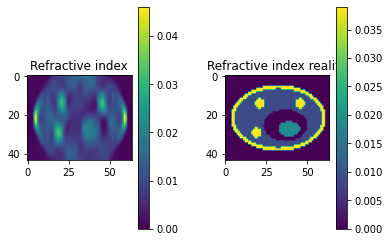

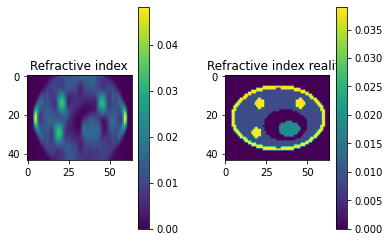

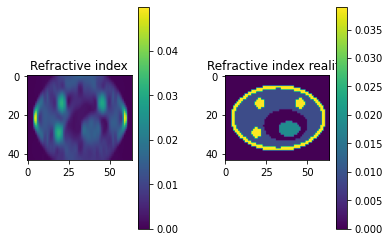

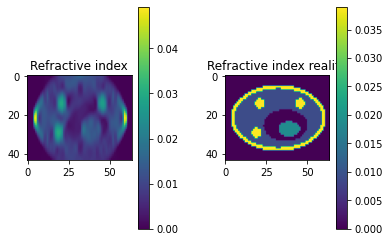

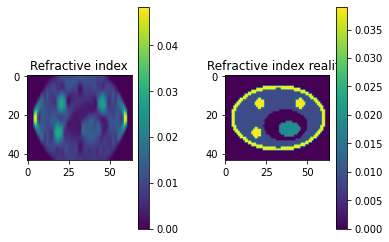

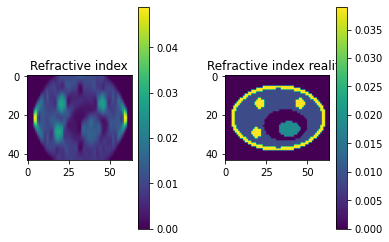

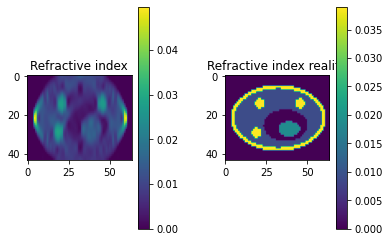

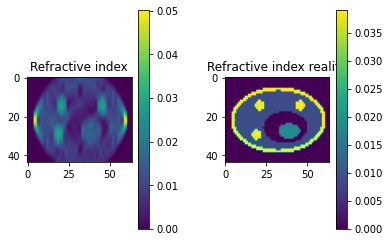

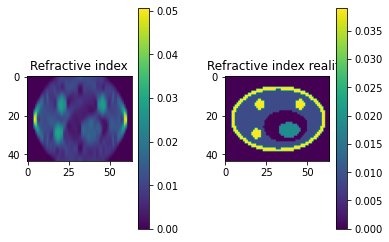

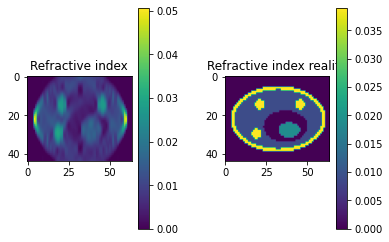

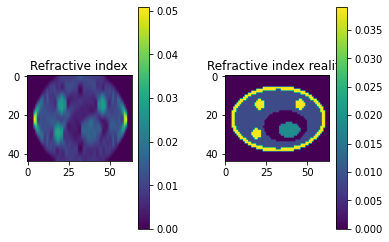

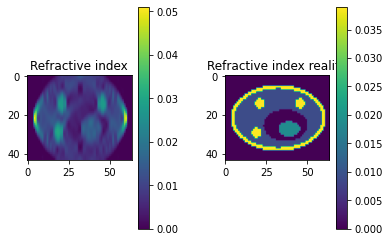

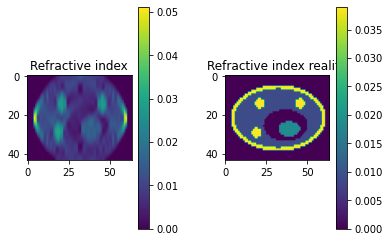

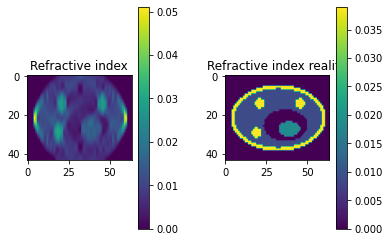

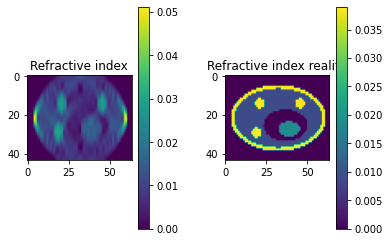

57.120532512664795


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MuScat')
from MuScatObject import MuScatObject
from MuScatField import MuScatField
from MuScatParameters import MuScatParameters
from MuScatMicroscopeSim import MuScatMicroscopeSim
import tensorflow as tf
import tensorflow_addons as tfa
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io



# ==========================================================
# MAKE SURE THAT X AND Y SIZE OF THE GRID FOR SIMULATION IS EVEN!!!
# I probably assumed that in the implementation from the begining
# ==========================================================

# NOA63 glue - refractive index = 1.5559 at 650nm
# soda-lime glass - refractive index = 1.5210 at 650nm - questionable for my spheres
# PVP (gel) - refractive index = 1.5245 at 650nm
# PVA (gel) - refractive index = 1.4757 at 650nm
# water - refractive index = 1.3310 at 650nm

refrIndM = 1.331
start = time.time()
# Illumination in most of the cases with 20x objective with NA=0.5
# Detection with 40x objective NA=0.95
parameters = MuScatParameters(0.650,        # wavelength in vacuum
                              [44, 64,64], # gridSize [z, x ,y]
                              0.15*1.5,          # dx
                              0.15*1.5,          # dy
                              0.2*refrIndM,          # dz
                              refrIndM,          # refractive index in medium
                              0.90,          # NAc
                              0.95)          # NAo
zsampling = 3

regLambdaL1 = 0.0000008
regLambdaL2 = 0.000
regLambdaTV = 0.00003
learnRate = 0.8

centerInd = np.int32(parameters.gridSize[1]/2)

imagingSim = MuScatMicroscopeSim(parameters)

MuScatMethod = 'MLB'
shift1 = 0.5
refShifts = tf.cast(tf.constant([[shift1, shift1],[0., 0.],[-shift1, shift1],[shift1, -shift1], [-shift1, -shift1]]), tf.float32)
refShifts = tf.cast(tf.constant([[0., 0.]]), tf.float32)
#refShifts = tf.cast(tf.constant([[0.,shift1]]), tf.float32)
# Initialize Illumination and detection part
imagingSim.Illumination(HollowCone=0.0, sampling=1, shift=[0,0])
imagingSim.Detection()

Piston = 0.   #    1: "Piston",
Xtilt = 0.    #    2: "Tip (lateral position) (X-Tilt)",
Ytilt = 0.    #    3: "Tilt (lateral position) (Y-Tilt)",
Defocus = 0.  #    4: "Defocus (longitudinal position)",
Oastig = 0.   #    5: "Oblique astigmatism",
Vastig = 0.   #    6: "Vertical astigmatism",
Vcoma = 0.   #    7: "Vertical coma",
Hcoma = 0.    #    8: "Horizontal coma",
Vtrefoil = 0. #    9: "Vertical trefoil",
Otrefoil = 0. #    10: "Oblique trefoil",
Spherical = 0.#    11: "Primary spherical",
#    12: "Vertical secondary astigmatism",
#    13: "Oblique secondary astigmatism",
#    14: "Vertical quadrafoil",
#    15: "Oblique quadrafoil"

zernCoef = tf.Variable([[Piston, Xtilt, Ytilt, Defocus, Oastig, Vastig,
                         Vcoma, Hcoma, Vtrefoil, Otrefoil, Spherical]], tf.float32)
imagingSim.ZernikeCoefficients = zernCoef;

# Initialize object containing refractive index Variable-Tensor to be optimized
optimizedObject = MuScatObject(parameters, initial_value=0., min_value=0.00, max_value=0.08,)

# Define focal positions for z-Stack creation
zPositions = optimizedObject.realzzz[::zsampling,0,0] - optimizedObject.realzzz[0,0,0]

# Create object that will be imaged in case of pure simulation
imagedObject = MuScatObject(parameters)
imagedObject.GenerateElipsoidNP(6.5, 6.5, 4.5, [0.,0.,0.], 1.37) # cell border
imagedObject.GenerateElipsoidNP(6., 6., 4., [0.,0.,0.], 1.34)   # cell inside
imagedObject.GenerateElipsoidNP(2., 3.5, 2.5, [1.,1.,1.], refrIndM)  # zero diff
imagedObject.GenerateElipsoidNP(1., 1.5, 1., [1.5,0.,1.5], 1.35)  # nucleus
imagedObject.GenerateSphereNP(0.5, [-3.,-1.,-1.5], 1.37)   # small features
imagedObject.GenerateSphereNP(0.5, [-2.,0.,-2.5], 1.37)
imagedObject.GenerateSphereNP(0.5, [-2.,-3.,-0.], 1.37)
imagedObject.GenerateSphereNP(0.5, [2.,0.,-3.], 1.37)
imagedObject.GenerateSphereNP(0.5, [-2.,0.,3.], 1.37)

# Simulate light propagation through defined imagedObject
fieldSimulated = MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
    imagedObject, method=MuScatMethod)

# Generate z-Stack measurement with CCHM from simulated scattered field
zStackSimulated = imagingSim.CCHMImaging(fieldSimulated, zPositions, refShifts) 

# in case of imaging a Bead, check validity of set parameters based on the 
# comparison of simulated and measured data
plt.figure(11)
plt.subplot(121),plt.colorbar(plt.imshow(
    np.angle(zStackSimulated[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated phase')
plt.subplot(122),plt.colorbar(plt.imshow(
    np.abs(zStackSimulated[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated amplitude')

plt.show()

# in case of Adam or other TF optimizers use this regularizer func. to
# specify L1 and L2 regularization
regularizer = tf.keras.regularizers.L1L2(regLambdaL1, regLambdaL2)
#opt = tf.keras.optimizers.Adam(learning_rate=learnRate)

# Some optimizers such as Yogi have l1 and l2 as parameters
# Yogi is steepest gradient descent based optimizer
# ProximalAdagrad
opt = tfa.optimizers.Yogi(learning_rate=learnRate,
                          l1_regularization_strength = regLambdaL1,
                          l2_regularization_strength = regLambdaL2)

imagingSim.Compute3DCTF(refShifts)

def regTV(variable, parameter):
    diffZ = (variable - tf.roll(variable,1,0))
    diffX = (variable - tf.roll(variable,1,1))
    diffY = (variable - tf.roll(variable,1,2))
    return parameter * tf.reduce_sum(tf.sqrt(diffZ**2 + diffX**2 + diffY**2 + \
                                             tf.keras.backend.epsilon()))

Piston = 0.   #    1: "Piston",
Xtilt = 0.    #    2: "Tip (lateral position) (X-Tilt)",
Ytilt = 0.    #    3: "Tilt (lateral position) (Y-Tilt)",
Defocus = 0.  #    4: "Defocus (longitudinal position)",
Oastig = 0.   #    5: "Oblique astigmatism",
Vastig = 0.   #    6: "Vertical astigmatism",
Vcoma = 0.    #    7: "Vertical coma",
Hcoma = 0.    #    8: "Horizontal coma",
Vtrefoil = 0. #    9: "Vertical trefoil",
Otrefoil = 0. #    10: "Oblique trefoil",
Spherical = 0.#    11: "Primary spherical",
#    12: "Vertical secondary astigmatism",
#    13: "Oblique secondary astigmatism",
#    14: "Vertical quadrafoil",
#    15: "Oblique quadrafoil"

zernCoef2 = tf.Variable([[Piston, Xtilt, Ytilt, Defocus, Oastig, Vastig,
                         Vcoma, Hcoma, Vtrefoil, Otrefoil, Spherical]],
                         tf.float32)
imagingSim.ZernikeCoefficients = zernCoef;

@tf.function
def loss_fn(zStackSimulated, zStackMeasured):
    return tf.reduce_mean(tf.abs(zStackMeasured - zStackSimulated)**2) #+ regTV(optimizedObject.RIDistrib, regLambdaTV)
        #regularizer(optimizedObject.RIDistrib) #+ regTV(optimizedObject.RIDistrib, 0.0005)


loss = lambda: loss_fn(imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
        optimizedObject, method=MuScatMethod),
        zPositions,
        refShifts),
        zStackSimulated)

lossF = [ ]
for i in range(100):
    opt_op = opt.minimize(loss, var_list=[optimizedObject.RIDistrib])
    if i%5==0:
        #lossF.append(loss().numpy())
        plt.figure(1)
        plt.subplot(121),plt.colorbar(plt.imshow(
            optimizedObject.RIDistrib[:, centerInd, :],
            aspect=parameters.dz/parameters.dx))
        plt.title('Refractive index')
        plt.subplot(122),plt.colorbar(plt.imshow(
            imagedObject.RIDistrib[:, centerInd, :],
            aspect=parameters.dz/parameters.dx))
        plt.title('Refractive index reality')
        plt.tight_layout(pad=3.0)
        #plt.subplot(133),plt.plot(lossF)
        plt.show()

print(time.time()-start)

In [ ]:
!pip install pyevtk
from pyevtk.hl import gridToVTK
from pyevtk.hl import imageToVTK
#gridToVTK(
#    "./RIDistrib",
#    imagedObject.realzzz.numpy(),
#    imagedObject.realxxx.numpy(),
#    imagedObject.realyyy.numpy(),
#    pointData={"RIDistrib": optimizedObject.RIDistrib.numpy()},
#    )

imageToVTK(
    "./RIDistribSimCELL_Zstack",
    spacing = (parameters.dz/parameters.dx,1.0,1.0),
    cellData={"RIDistrib": imagedObject.RIDistrib.numpy()},
    
)


'/content/RIDistribSimCELLGroundTruth.vti'

Text(0.5, 1.0, 'Deconv RIdiff')

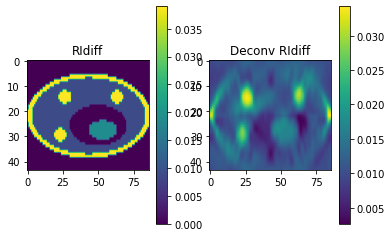

In [ ]:
imagingSim.ZernikeCoefficients = -zernCoef;
imagingSim.Compute3DCTF(refShifts)
deconvPot = imagingSim.CCHMdeconvolution(zStackSimulated[0,:,:,:],1e-3)
plt.figure(13)
plt.subplot(121),plt.colorbar(plt.imshow(
    (imagedObject.RIDistrib[:, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('RIdiff')
plt.subplot(122),plt.colorbar(plt.imshow(
    (deconvPot[ :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Deconv RIdiff')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f33894b7210>,
 <matplotlib.colorbar.Colorbar at 0x7f3389340490>)

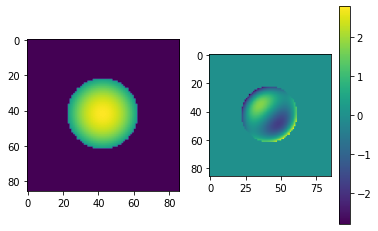

In [ ]:
plt.figure
plt.subplot(121),plt.imshow(np.abs(imagingSim.SPupil[22,:,:]))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(imagingSim.SPupil[22,:,:])))

tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)
(1, 44, 86, 86)


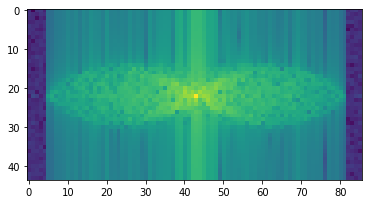

In [ ]:

plt.figure(5),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[0, :, centerInd, :]))))))
#plt.figure(6),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[1, :, centerInd, :]))))))
#plt.figure(7),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[2, :, centerInd, :]))))))
#plt.figure(8),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[3, :, centerInd, :]))))))
#plt.figure(9),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[4, :, centerInd, :]))))))

print(refShifts)
print(np.shape(zStackSimulated.numpy()))

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fbf4f264e48>)

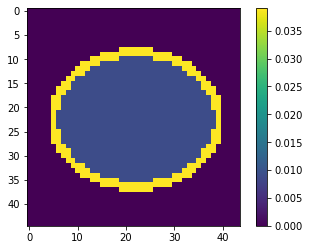

In [ ]:
plt.figure(105),plt.colorbar(plt.imshow(imagedObject.RIDistrib[:, 32, :]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0217716ed0>,
 <matplotlib.colorbar.Colorbar at 0x7f0217755550>)

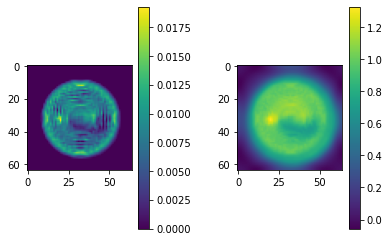

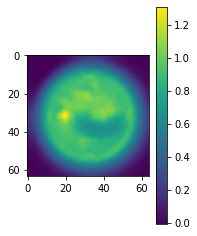

In [ ]:
zStackSim = imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
        optimizedObject, method=MuScatMethod),
        zPositions,
        refShifts)
index = 35
plt.figure(55)
plt.subplot(121),plt.colorbar(plt.imshow(optimizedObject.RIDistrib[index, :, :]))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackSimulated[0, index, :, :])))

plt.tight_layout(pad=3.0)
plt.figure(56)
plt.subplot(121),plt.colorbar(plt.imshow(np.angle(zStackSim[0, index, :, :])))